In [719]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import os
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


In [720]:
df =pd.read_csv('./file_csv/flight/all_flight_EDA.csv')
# 'date' 컬럼을 날짜 데이터로 변환
df['date'] = pd.to_datetime(df['date'])

# 각 날짜 정보를 컬럼으로 바꾸기
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['days'] = df['date'].dt.day

def set_peak_season(month, date):
    date_str = date.strftime('%Y-%m-%d')
    if month == 8 and date_str <= '2023-08-19':
        return '성수기'
    elif date_str in ['2023-09-27','2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-09', '2023-10-10']:
        return '성수기'
    else:
        return '비수기'

df['peak_season'] = df.apply(lambda row: set_peak_season(row['month'], row['date']), axis=1)

# 시간을 분 단위로 변환하는 함수 정의
def convert_time_to_minutes(time_str):
    hour, minute = map(int, time_str.split(':'))
    return hour * 60 + minute

df['date'] = pd.to_datetime(df['date'])

# departure_time과 arrival_time을 분 단위로 변환
df['departure_time'] = df['departure_time'].apply(convert_time_to_minutes)
df['arrival_time'] = df['arrival_time'].apply(convert_time_to_minutes)


display(df)

,airline,date,departure_time,arrival_time,departure_place,arrival_place,flight_time,seat,price,day,holiday,year,month,days,peak_season
0,대한항공,2023-08-01,1000,1060,PUS,CJU,60,일반석,102700,화요일,평일,2023,8,1,성수기
1,제주항공,2023-08-01,1025,1080,PUS,CJU,55,일반석,99700,화요일,평일,2023,8,1,성수기
2,에어부산,2023-08-01,1050,1110,PUS,CJU,60,일반석,99700,화요일,평일,2023,8,1,성수기
3,에어부산,2023-08-01,1080,1140,PUS,CJU,60,일반석,99700,화요일,평일,2023,8,1,성수기
4,진에어,2023-08-01,1140,1200,PUS,CJU,60,일반석,95700,화요일,평일,2023,8,1,성수기
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43444,제주항공,2023-10-31,525,595,CJU,GMP,70,특가석,42600,화요일,평일,2023,10,31,비수기
43445,티웨이항공,2023-10-31,525,595,CJU,GMP,70,일반석,82700,화요일,평일,2023,10,31,비수기
43446,제주항공,2023-10-31,525,595,CJU,GMP,70,일반석,82700,화요일,평일,2023,10,31,비수기
43447,아시아나항공,2023-10-31,540,610,CJU,GMP,70,할인석,60700,화요일,평일,2023,10,31,비수기


In [721]:
print(df['flight_time'].unique())

[60 55 65 70 75 80 50]


In [722]:
flight_time_80_df = df[df['flight_time'] == 80]

display(flight_time_80_df)

,airline,date,departure_time,arrival_time,departure_place,arrival_place,flight_time,seat,price,day,holiday,year,month,days,peak_season
101,에어부산,2023-08-01,405,485,GMP,CJU,80,할인석,80540,화요일,평일,2023,8,1,성수기
102,에어부산,2023-08-01,405,485,GMP,CJU,80,일반석,118700,화요일,평일,2023,8,1,성수기
111,에어부산,2023-08-01,430,510,GMP,CJU,80,할인석,80540,화요일,평일,2023,8,1,성수기
112,에어부산,2023-08-01,430,510,GMP,CJU,80,일반석,118700,화요일,평일,2023,8,1,성수기
129,에어부산,2023-08-01,500,580,GMP,CJU,80,할인석,115520,화요일,평일,2023,8,1,성수기
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42898,제주항공,2023-10-27,930,1010,PUS,CJU,80,일반석,99700,금요일,주말,2023,10,27,비수기
42979,에어부산,2023-10-27,405,485,GMP,CJU,80,일반석,118700,금요일,주말,2023,10,27,비수기
43020,제주항공,2023-10-28,930,1010,PUS,CJU,80,할인석,80600,토요일,주말,2023,10,28,비수기
43021,제주항공,2023-10-28,930,1010,PUS,CJU,80,일반석,99700,토요일,주말,2023,10,28,비수기


In [723]:
flight_time_counts = df['flight_time'].value_counts()

percent = (flight_time_counts / len(df)) * 100

print('\nflight time을 기준으로 한 비율')
print(percent)


flight time을 기준으로 한 비율
flight_time
70   63.30
60   14.49
65   10.45
75    7.47
55    2.07
80    2.03
50    0.18
Name: count, dtype: float64


In [724]:
avg_airline_flight_time=df.groupby('airline')['flight_time'].mean()
print('\n항공사별 평균 flight time')
print(avg_airline_flight_time)


항공사별 평균 flight time
airline
대한항공     68.49
아시아나항공   69.39
에어로케이    66.54
에어부산     65.68
에어서울     68.23
이스타항공    68.84
제주항공     67.90
진에어      67.35
티웨이항공    69.15
Name: flight_time, dtype: float64


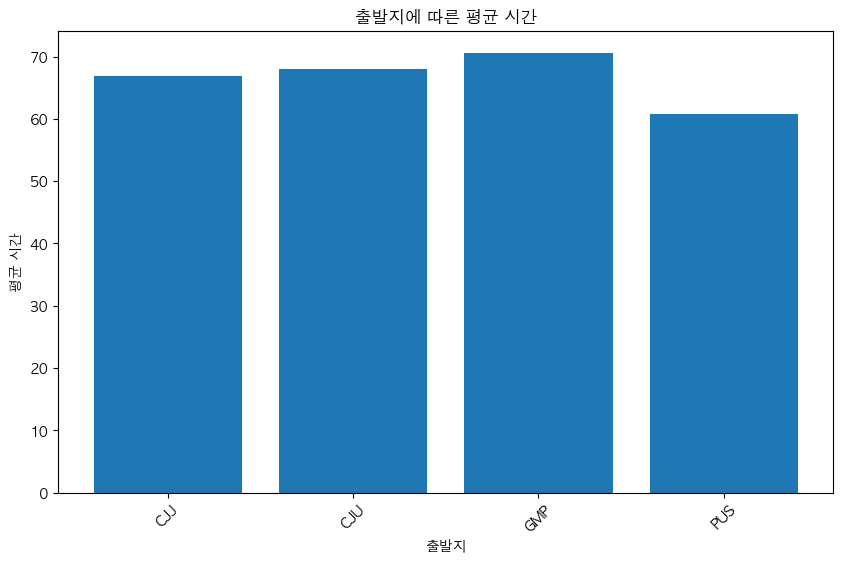

In [725]:
g_df = df.groupby('departure_place')['flight_time'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(g_df['departure_place'], g_df['flight_time'])
plt.xlabel('출발지')
plt.ylabel('평균 시간')
plt.title('출발지에 따른 평균 시간')
plt.xticks(rotation=45)
plt.show()

In [726]:
print(' 데이터의 구조')
print(df.shape)
print('\n 데이터의 정보')
df.info()

 데이터의 구조
(43449, 15)

 데이터의 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43449 entries, 0 to 43448
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          43449 non-null  object        
 1   date             43449 non-null  datetime64[ns]
 2   departure_time   43449 non-null  int64         
 3   arrival_time     43449 non-null  int64         
 4   departure_place  43449 non-null  object        
 5   arrival_place    43449 non-null  object        
 6   flight_time      43449 non-null  int64         
 7   seat             43449 non-null  object        
 8   price            43449 non-null  int64         
 9   day              43449 non-null  object        
 10  holiday          43449 non-null  object        
 11  year             43449 non-null  int32         
 12  month            43449 non-null  int32         
 13  days             43449 non-null  int32         
 14  peak_se

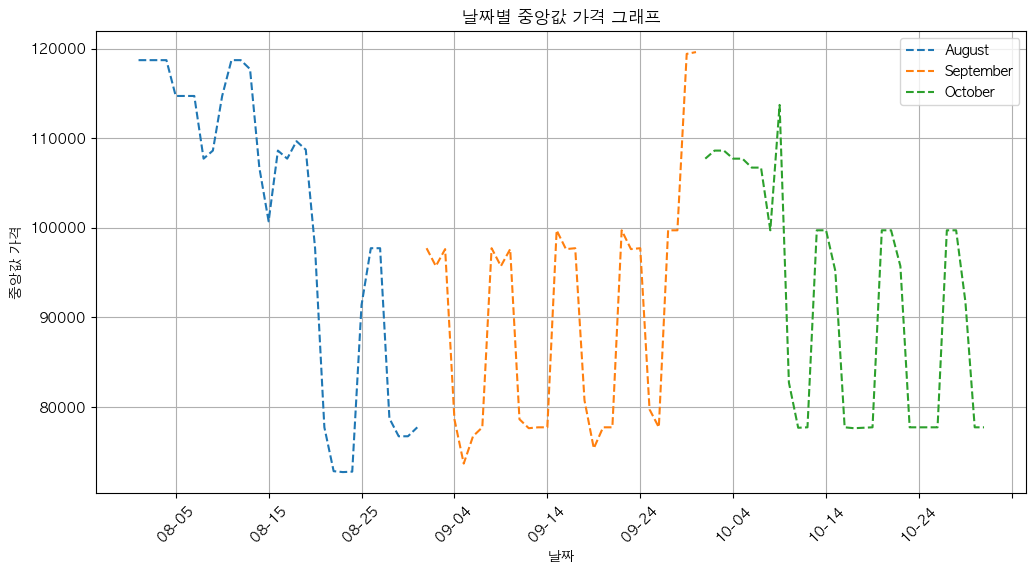

In [727]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')

# 8, 9, 10월 구간 설정
df_agt = df[(df['date'] >= '2023-08-01') & (df['date'] <= '2023-08-31')]
df_stp = df[(df['date'] >= '2023-09-01') & (df['date'] <= '2023-09-30')]
df_oct = df[(df['date'] >= '2023-10-01') & (df['date'] <= '2023-10-31')]

# 각 구간별 가격 중앙값 계산
med_agt = df_agt.groupby('month_day')['price'].median()
med_stp = df_stp.groupby('month_day')['price'].median()
med_oct = df_oct.groupby('month_day')['price'].median()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(med_agt.index, med_agt.values, label='August', linestyle='dashed')
plt.plot(med_stp.index, med_stp.values, label='September', linestyle='dashed')
plt.plot(med_oct.index, med_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('중앙값 가격')
plt.title('날짜별 중앙값 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

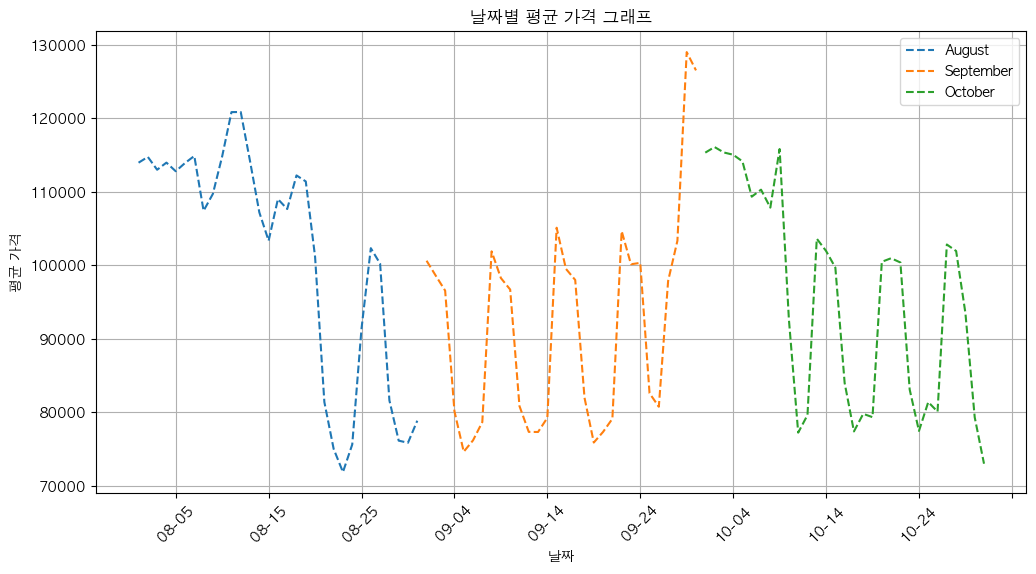

In [728]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')


# 각 구간별 가격 평균값 계산
avg_agt = df_agt.groupby('month_day')['price'].mean()
avg_stp = df_stp.groupby('month_day')['price'].mean()
avg_oct = df_oct.groupby('month_day')['price'].mean()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(avg_agt.index, avg_agt.values, label='August', linestyle='dashed')
plt.plot(avg_stp.index, avg_stp.values, label='September', linestyle='dashed')
plt.plot(avg_oct.index, avg_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('평균 가격')
plt.title('날짜별 평균 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [729]:
def divide_data_by_month(df, month):
    return df[df['month'] == month]

def limit(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
    return lower_bound, upper_bound


# Boxplot 함수
def boxplot(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    sns.boxplot(x=column, ax=ax1)

    sns.boxplot(x=column, ax=ax2)
    ax2.set_xlim(lower_bound, upper_bound)

    plt.show()

# Histogram 함수
def histogram(column, month_data):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=month_data, x=column, kde=True)
    plt.title(f'Histogram - {column} (Month: {month_data["month"].iloc[0]})')
    plt.show()

# Violinplot 함수
def violinplot(column, month_data):
    day_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=month_data, x='day', y=column, order=day_order, palette='cool', split=True)
    plt.title(f'Violin Plot - {column} (Month: {month_data["month"].iloc[0]})')
    plt.show()

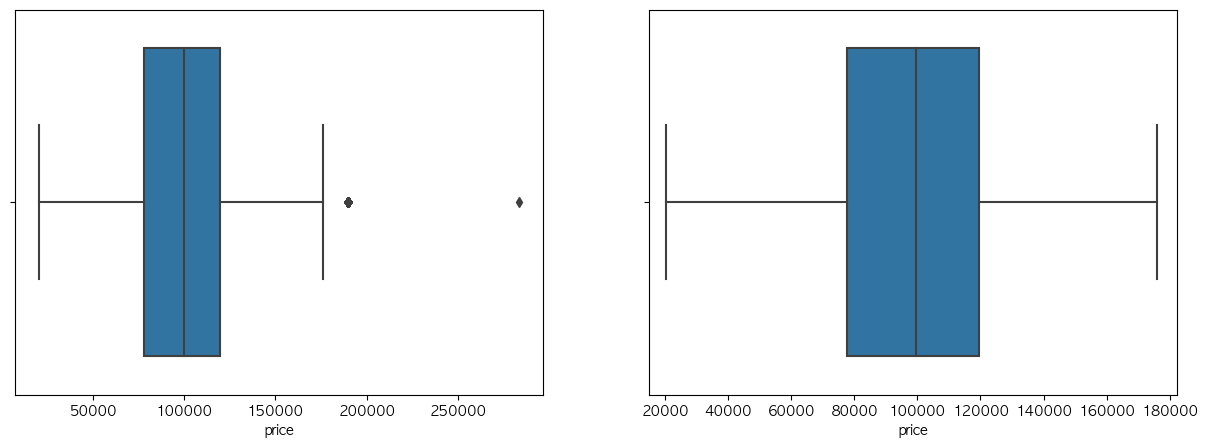

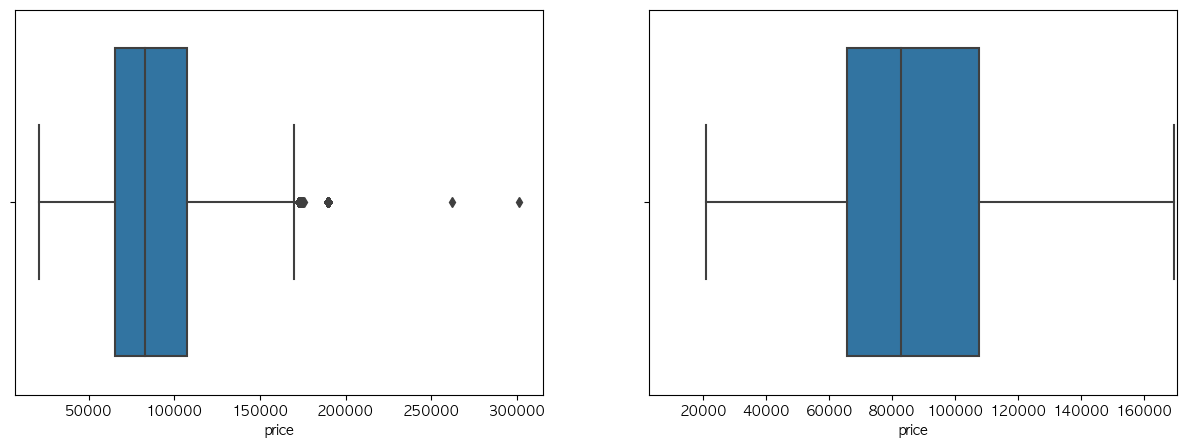

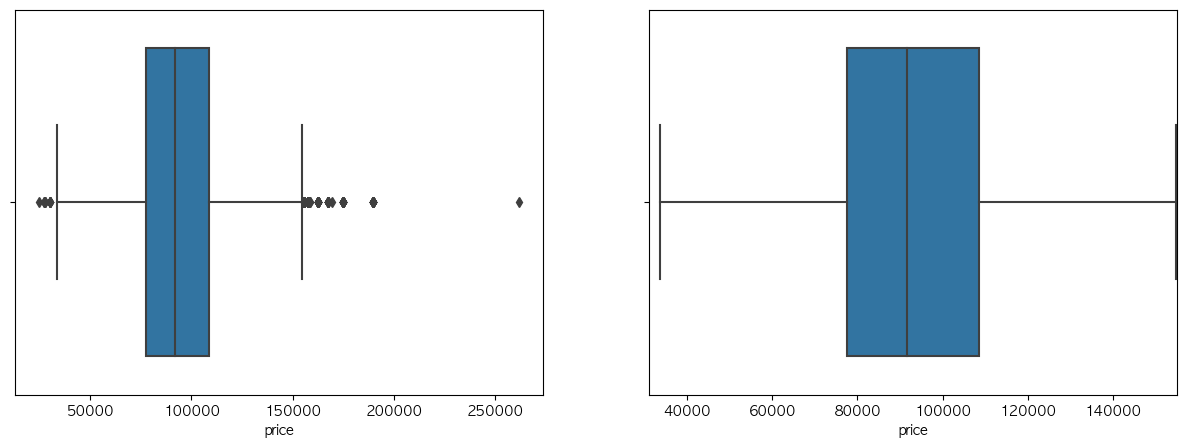

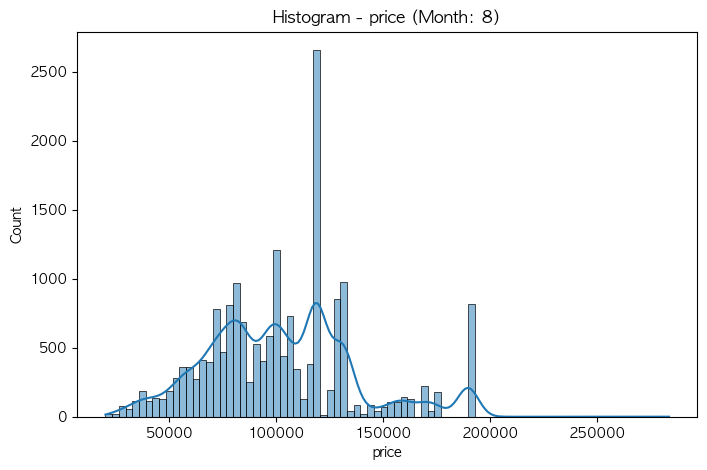

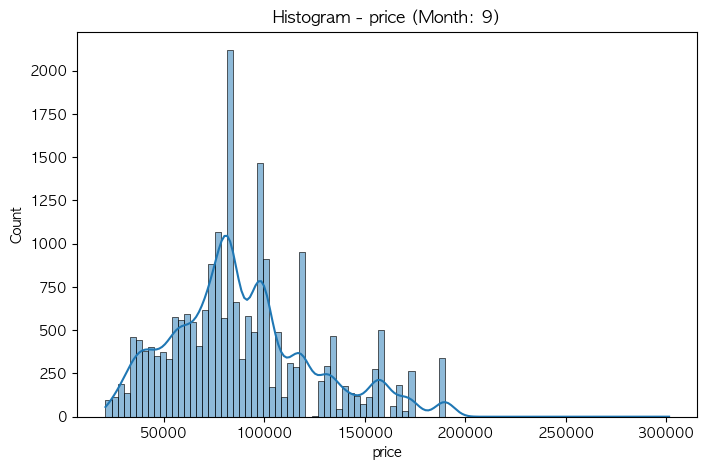

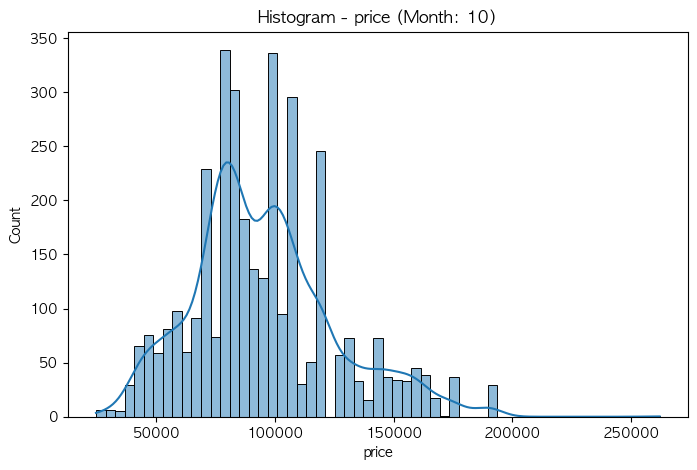

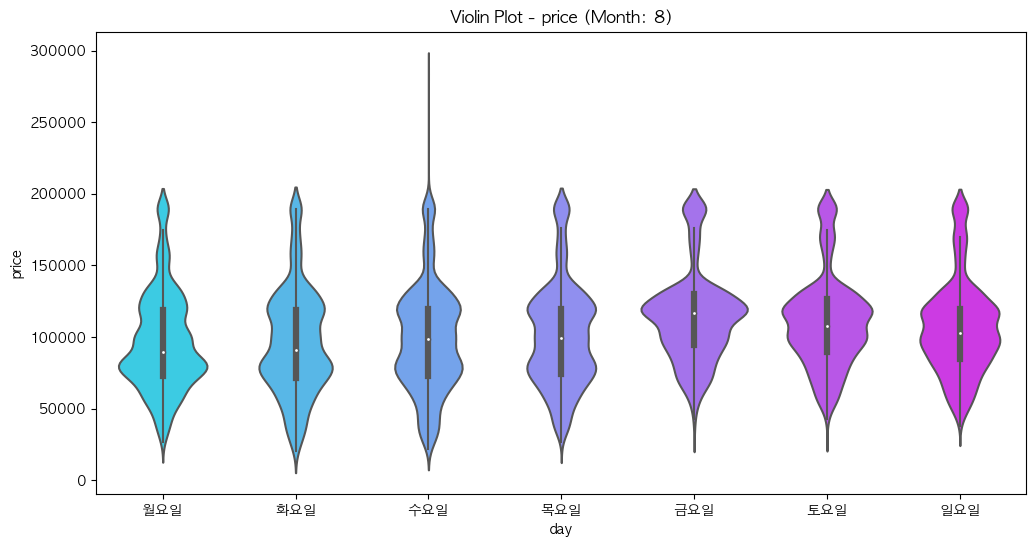

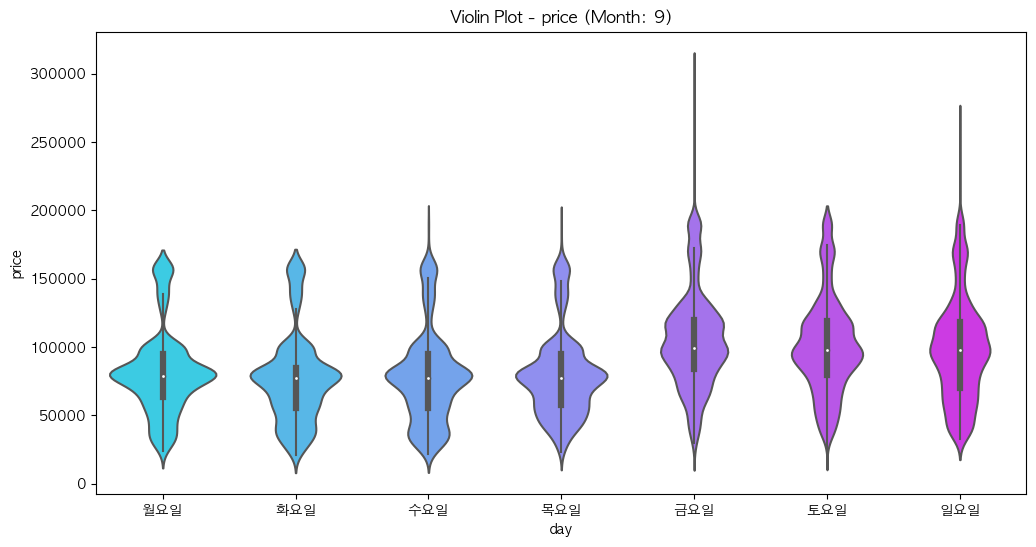

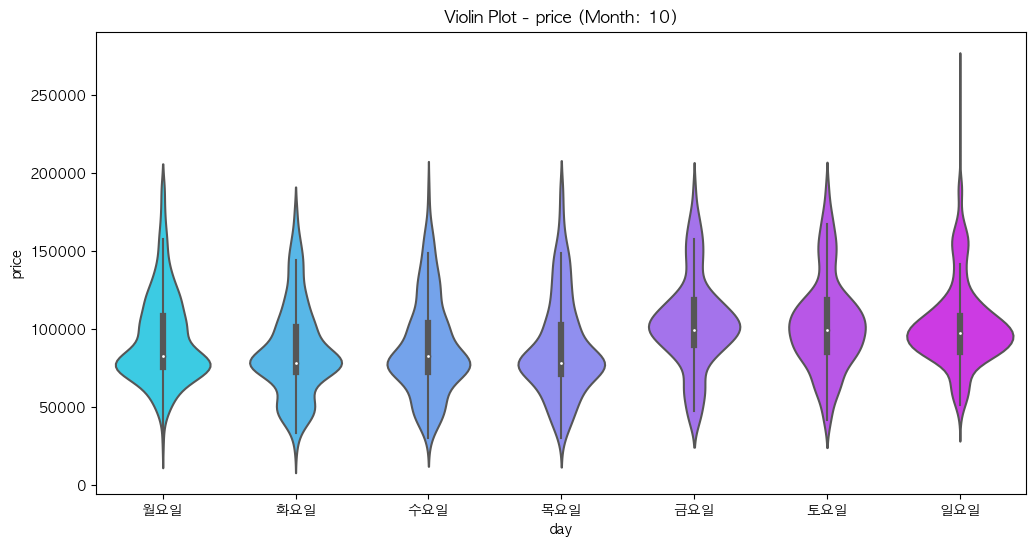

In [730]:
month_8_data = divide_data_by_month(df, 8)
month_9_data = divide_data_by_month(df, 9)
month_10_data = divide_data_by_month(df, 10)

# 월별 그래프 그리기
boxplot(month_8_data['price'])
boxplot(month_9_data['price'])
boxplot(month_10_data['price'])

histogram('price', month_8_data)
histogram('price', month_9_data)
histogram('price', month_10_data)

violinplot('price', month_8_data)
violinplot('price', month_9_data)
violinplot('price', month_10_data)

In [731]:
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]

    lim_inf, lim_sup = limit(df[nome_coluna])

    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]

    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

1192 linhas removidas


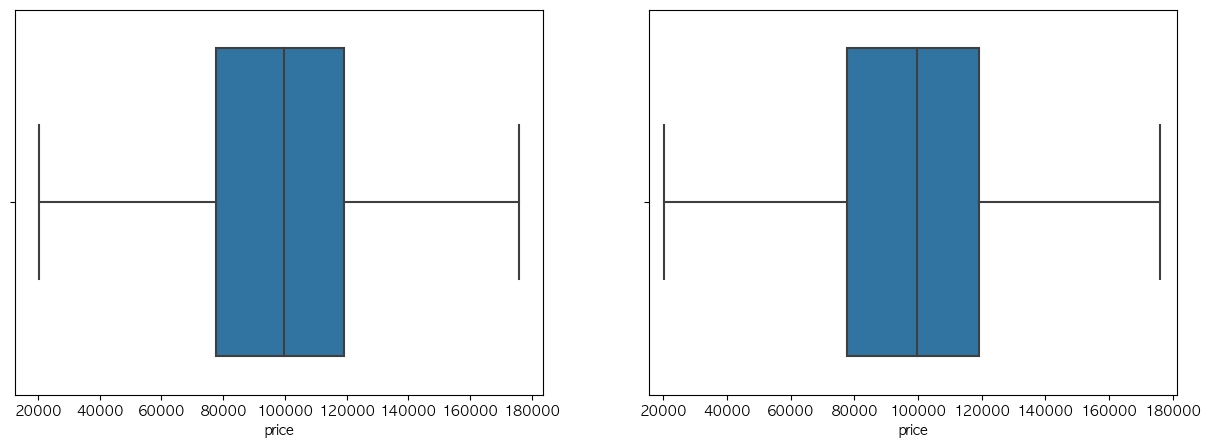

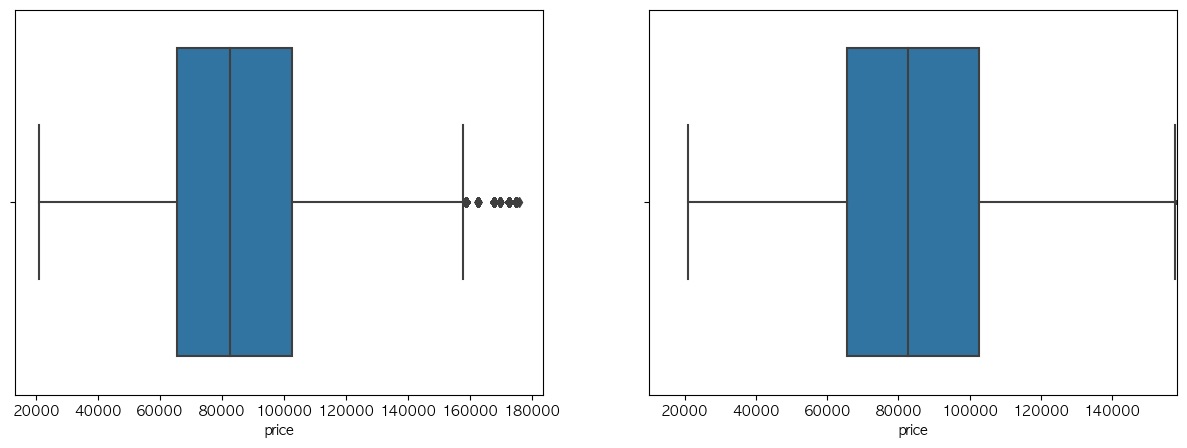

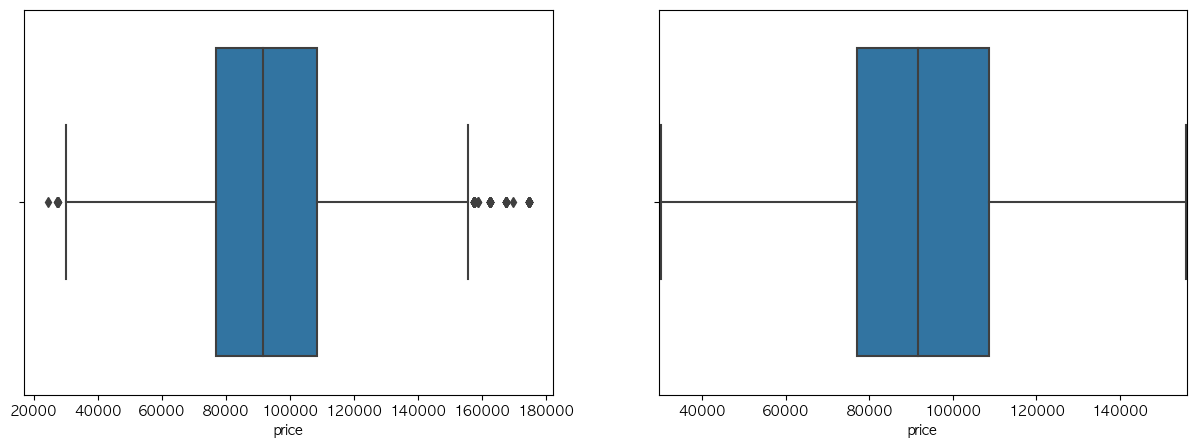

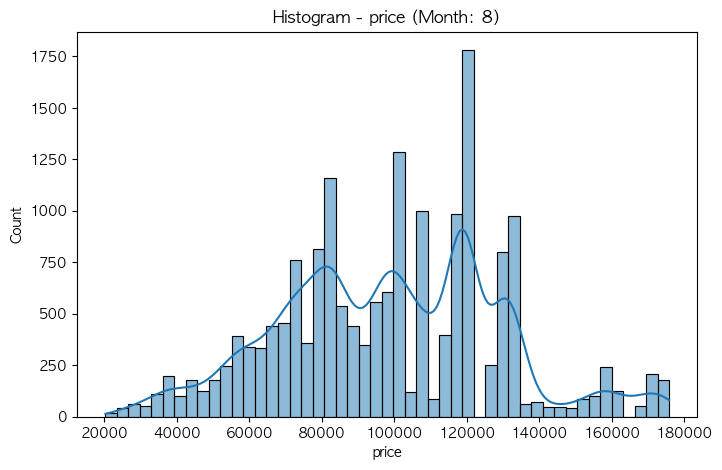

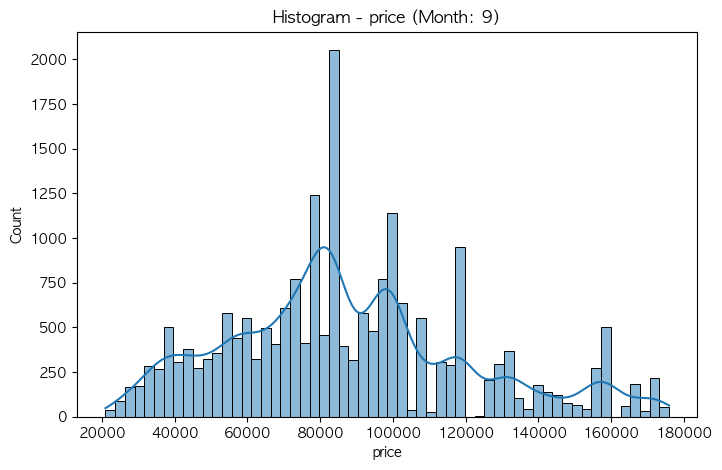

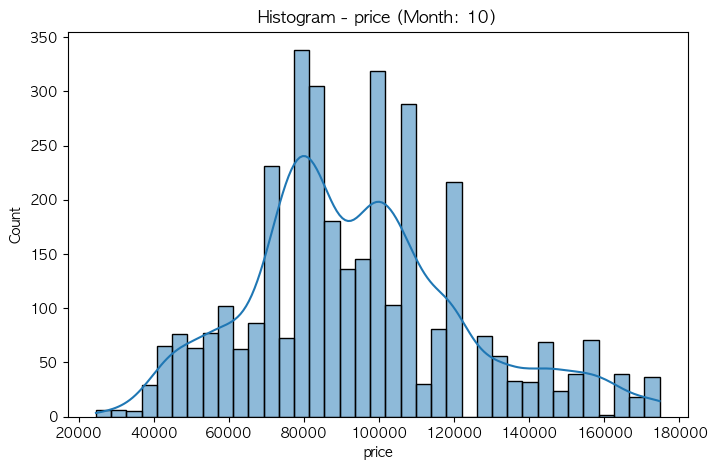

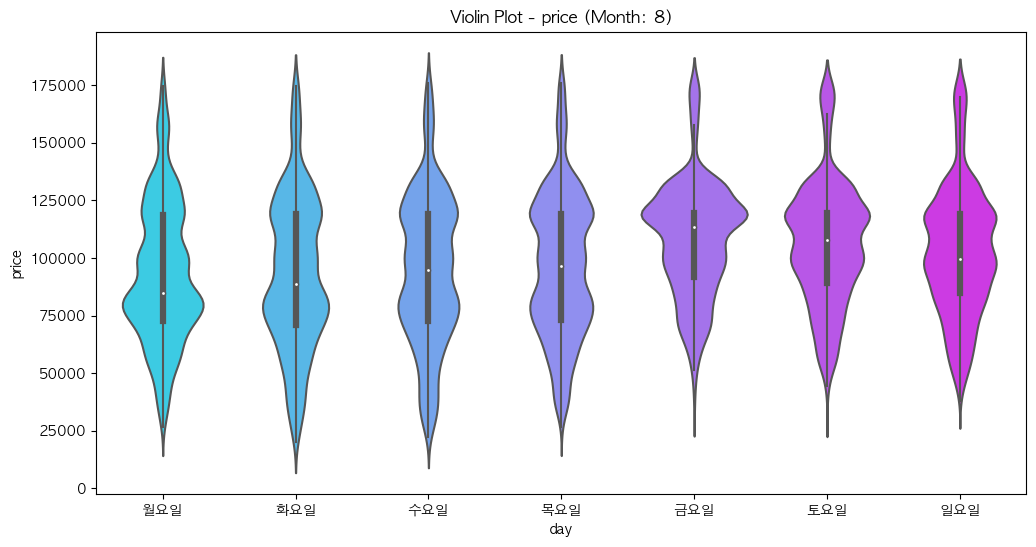

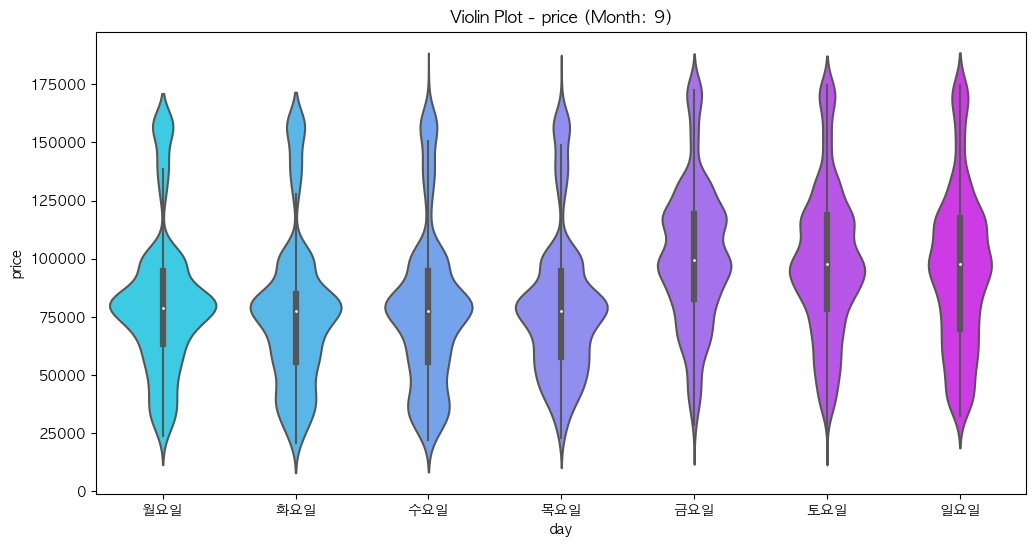

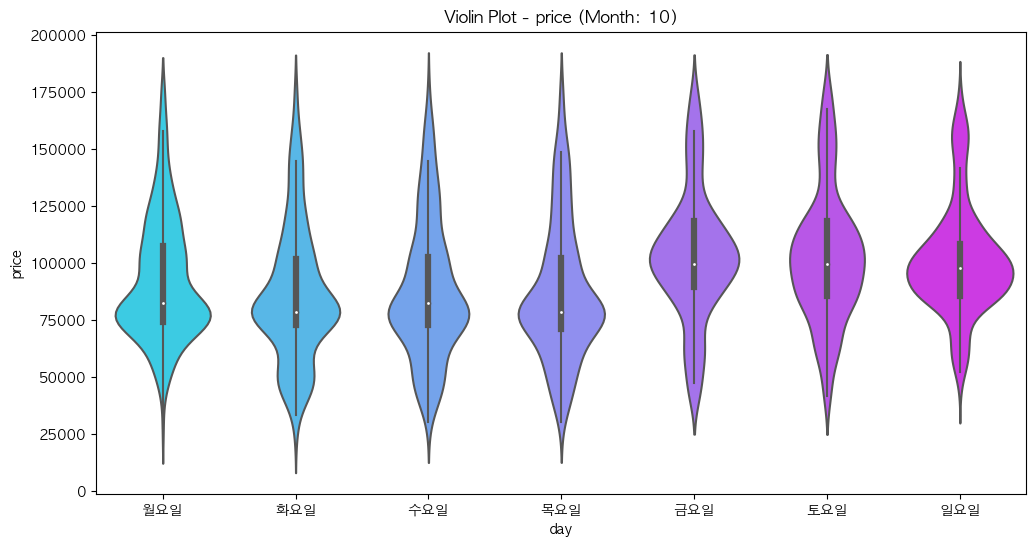

In [732]:
# 이상치 제거
df, linhas_removidas = excluir_outliers(df, 'price')
print('{} linhas removidas'.format(linhas_removidas))

# 월별 데이터 분할
month_8_data = divide_data_by_month(df, 8)
month_9_data = divide_data_by_month(df, 9)
month_10_data = divide_data_by_month(df, 10)

# 그래프 그리기
boxplot(month_8_data['price'])
boxplot(month_9_data['price'])
boxplot(month_10_data['price'])

histogram('price', month_8_data)
histogram('price', month_9_data)
histogram('price', month_10_data)

violinplot('price', month_8_data)
violinplot('price', month_9_data)
violinplot('price', month_10_data)

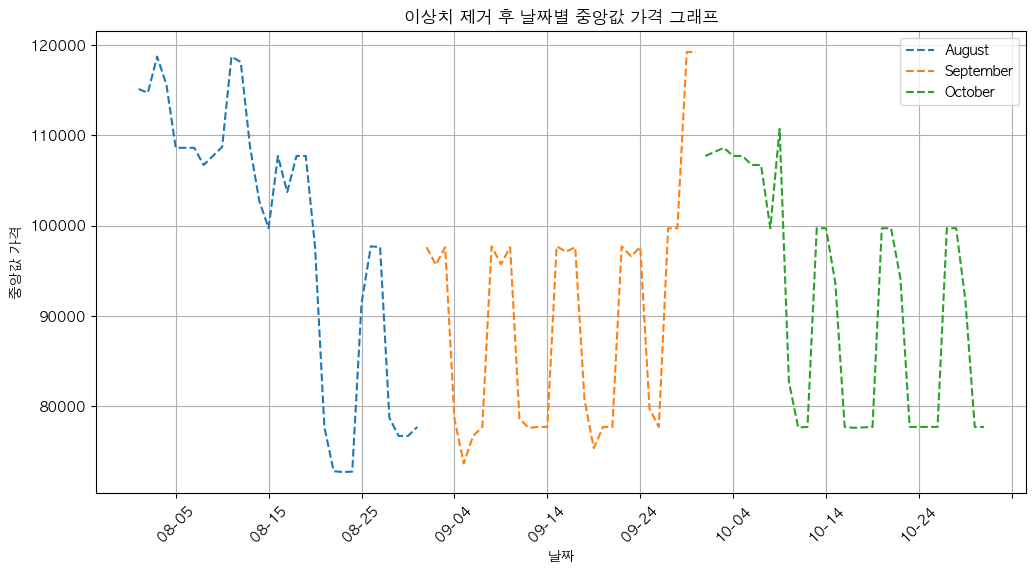

In [733]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')

# 8, 9, 10월 구간 설정
df_agt = df[(df['date'] >= '2023-08-01') & (df['date'] <= '2023-08-31')]
df_stp = df[(df['date'] >= '2023-09-01') & (df['date'] <= '2023-09-30')]
df_oct = df[(df['date'] >= '2023-10-01') & (df['date'] <= '2023-10-31')]

# 각 구간별 가격 중앙값 계산
med_agt = df_agt.groupby('month_day')['price'].median()
med_stp = df_stp.groupby('month_day')['price'].median()
med_oct = df_oct.groupby('month_day')['price'].median()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(med_agt.index, med_agt.values, label='August', linestyle='dashed')
plt.plot(med_stp.index, med_stp.values, label='September', linestyle='dashed')
plt.plot(med_oct.index, med_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('중앙값 가격')
plt.title('이상치 제거 후 날짜별 중앙값 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

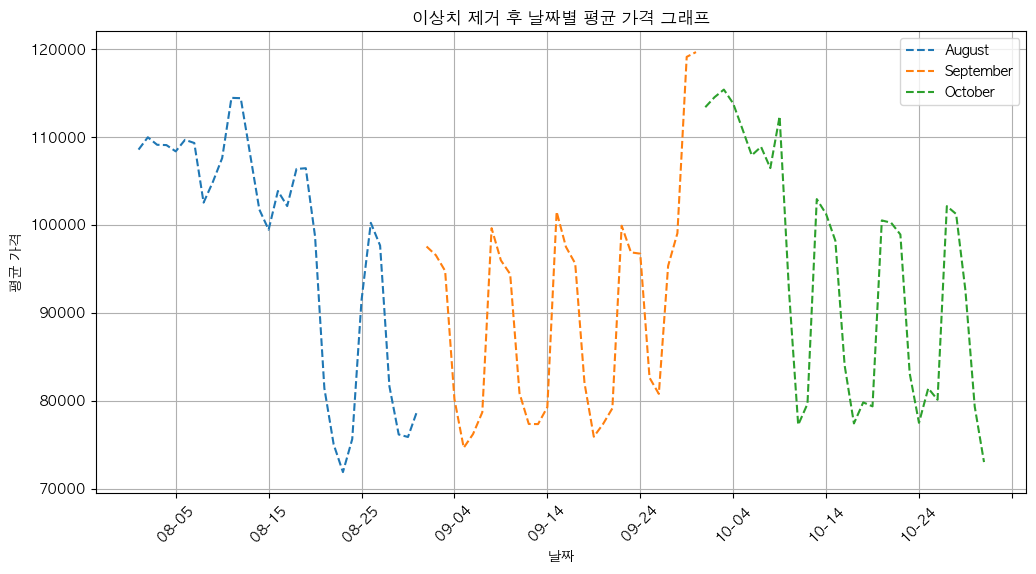

In [734]:
# date 날짜 형태로 바꾸기
df['date'] = pd.to_datetime(df['date'])

# month day 컬럼으로 월과 일만 받기
df['month_day'] = df['date'].dt.strftime('%m-%d')


# 각 구간별 가격 평균값 계산
avg_agt = df_agt.groupby('month_day')['price'].mean()
avg_stp = df_stp.groupby('month_day')['price'].mean()
avg_oct = df_oct.groupby('month_day')['price'].mean()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(avg_agt.index, avg_agt.values, label='August', linestyle='dashed')
plt.plot(avg_stp.index, avg_stp.values, label='September', linestyle='dashed')
plt.plot(avg_oct.index, avg_oct.values, label='October', linestyle='dashed')
plt.xlabel('날짜')
plt.ylabel('평균 가격')
plt.title('이상치 제거 후 날짜별 평균 가격 그래프')

# 10일 마다 x축 표시
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))

plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [735]:
df_ml = df.copy()
# 라벨 인코딩을 적용할 컬럼들 선택
columns_to_encode = ["airline", "seat", "day", "holiday", "departure_place", "arrival_place", "peak_season"]

# 라벨 인코더 생성 및 적용
label_encoders = {}
for column in columns_to_encode:
    label_encoder = LabelEncoder()
    df_ml[column] = label_encoder.fit_transform(df_ml[column])
    label_encoders[column] = label_encoder

# 인코딩 이전의 데이터와 인코딩된 후의 데이터 비교
for column in columns_to_encode:
    print(f"Encoding for '{column}' column:")
    mapping = dict(zip(label_encoders[column].classes_, label_encoders[column].transform(label_encoders[column].classes_)))
    print(mapping)
    print()

Encoding for 'airline' column:
{'대한항공': 0, '아시아나항공': 1, '에어로케이': 2, '에어부산': 3, '에어서울': 4, '이스타항공': 5, '제주항공': 6, '진에어': 7, '티웨이항공': 8}

Encoding for 'seat' column:
{'비즈니스석': 0, '일반석': 1, '특가석': 2, '할인석': 3}

Encoding for 'day' column:
{'금요일': 0, '목요일': 1, '수요일': 2, '월요일': 3, '일요일': 4, '토요일': 5, '화요일': 6}

Encoding for 'holiday' column:
{'공휴일': 0, '주말': 1, '평일': 2}

Encoding for 'departure_place' column:
{'CJJ': 0, 'CJU': 1, 'GMP': 2, 'PUS': 3}

Encoding for 'arrival_place' column:
{'CJJ': 0, 'CJU': 1, 'GMP': 2, 'PUS': 3}

Encoding for 'peak_season' column:
{'비수기': 0, '성수기': 1}



In [736]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42257 entries, 0 to 43448
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          42257 non-null  int64         
 1   date             42257 non-null  datetime64[ns]
 2   departure_time   42257 non-null  int64         
 3   arrival_time     42257 non-null  int64         
 4   departure_place  42257 non-null  int64         
 5   arrival_place    42257 non-null  int64         
 6   flight_time      42257 non-null  int64         
 7   seat             42257 non-null  int64         
 8   price            42257 non-null  int64         
 9   day              42257 non-null  int64         
 10  holiday          42257 non-null  int64         
 11  year             42257 non-null  int32         
 12  month            42257 non-null  int32         
 13  days             42257 non-null  int32         
 14  peak_season      42257 non-null  int64     

In [737]:
display(df_ml)

,airline,date,departure_time,arrival_time,departure_place,arrival_place,flight_time,seat,price,day,holiday,year,month,days,peak_season,month_day
0,0,2023-08-01,1000,1060,3,1,60,1,102700,6,2,2023,8,1,1,08-01
1,6,2023-08-01,1025,1080,3,1,55,1,99700,6,2,2023,8,1,1,08-01
2,3,2023-08-01,1050,1110,3,1,60,1,99700,6,2,2023,8,1,1,08-01
3,3,2023-08-01,1080,1140,3,1,60,1,99700,6,2,2023,8,1,1,08-01
4,7,2023-08-01,1140,1200,3,1,60,1,95700,6,2,2023,8,1,1,08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43444,6,2023-10-31,525,595,1,2,70,2,42600,6,2,2023,10,31,0,10-31
43445,8,2023-10-31,525,595,1,2,70,1,82700,6,2,2023,10,31,0,10-31
43446,6,2023-10-31,525,595,1,2,70,1,82700,6,2,2023,10,31,0,10-31
43447,1,2023-10-31,540,610,1,2,70,3,60700,6,2,2023,10,31,0,10-31


In [738]:
display(df_ml['departure_time'].values)

array([1000, 1025, 1050, ...,  525,  540,  540])

In [739]:
# 'departure_time' 컬럼에 750이 있는지 확인
if 750 in df_ml['departure_time'].values:
    print("750이 'departure_time' 컬럼에 있습니다.")
else:
    print("750이 'departure_time' 컬럼에 없습니다.")

750이 'departure_time' 컬럼에 있습니다.


In [740]:

X = df_ml.drop(['year', 'price', 'arrival_time', 'month', 'days', 'month_day','date'], axis=1)
y = df_ml['price']

# train과 test 램덤하게 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤포레스트 모델 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost 모델 학습
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# CatBoost 모델 학습
catboost_model = CatBoostRegressor(random_state=42, verbose=False)
catboost_model.fit(X_train, y_train)

# 랜덤포레스트 모델 예측
y_test_pred_rf = rf_model.predict(X_test)

# xgbst 모델 예측
y_test_pred_xgb = xgb_model.predict(X_test)

# CatBoost 모델 예측
y_test_pred_catboost = catboost_model.predict(X_test)


In [741]:
column_list = X_train.columns.tolist()
print(column_list)

['airline', 'departure_time', 'departure_place', 'arrival_place', 'flight_time', 'seat', 'day', 'holiday', 'peak_season']


In [742]:
feature_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

           Feature  Importance
5             seat        0.50
7          holiday        0.16
8      peak_season        0.15
4      flight_time        0.06
3    arrival_place        0.04
0          airline        0.03
2  departure_place        0.02
6              day        0.01
1   departure_time        0.01


In [743]:
def eval_models(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred).round(3)
    rmse = np.sqrt(mse).round(3)
    mae = mean_absolute_error(y_true, y_pred).round(3)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

In [744]:
# 랜덤포레스트 성능확인
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
comparison_rf = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
baseline = [y_train.mean()] * len(y_train)
comparison_rf['Base'] = eval_models(y_train, baseline)
comparison_rf['Train'] = eval_models(y_train, y_train_pred_rf)
comparison_rf['Test'] = eval_models(y_test, y_test_pred_rf)

# XGBoost 성능확인
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
comparison_xgb = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
baseline = [y_train.mean()] * len(y_train)
comparison_xgb['Base'] = eval_models(y_train, baseline)
comparison_xgb['Train'] = eval_models(y_train, y_train_pred_xgb)
comparison_xgb['Test'] = eval_models(y_test, y_test_pred_xgb)

# catboost 성능확인
y_train_pred_catboost = catboost_model.predict(X_train)
y_test_pred_catboost =  catboost_model.predict(X_test)
comparison_catboost = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'], columns=['Base', 'Train', 'Test'])
baseline = [y_train.mean()] * len(y_train)
comparison_catboost['Base'] = eval_models(y_train, baseline)
comparison_catboost['Train'] = eval_models(y_train, y_train_pred_catboost)
comparison_catboost['Test'] = eval_models(y_test, y_test_pred_catboost)

In [745]:
pd.options.display.float_format = '{:,.2f}'.format
print("Random Forest 예측 성능:")
comparison_rf

Random Forest 예측 성능:


,Base,Train,Test
mse,"1,039,586,042.86","25,297,844.94","53,147,004.32"
rmse,"32,242.61","5,029.70","7,290.20"
mae,"25,911.68","2,253.18","3,308.28"
r2,0.00,0.98,0.95


In [746]:
print("\nXGBoost 예측 성능:")
comparison_xgb


XGBoost 예측 성능:


,Base,Train,Test
mse,"1,039,586,042.86","35,997,846.89","44,423,607.63"
rmse,"32,242.61","5,999.82","6,665.10"
mae,"25,911.68","3,478.45","3,812.36"
r2,0.00,0.97,0.96


In [747]:
print("\nCatboost 예측 성능:")
comparison_catboost


Catboost 예측 성능:


,Base,Train,Test
mse,"1,039,586,042.86","38,046,823.54","43,816,115.39"
rmse,"32,242.61","6,168.21","6,619.37"
mae,"25,911.68","3,619.36","3,845.86"
r2,0.00,0.96,0.96


In [748]:
# # 저장할 경로 변경
# os.chdir("model")

# # 모델을 파일에 피클링하여 저장
# with open('xgb_model_flight.pkl', 'wb') as file:
#     pickle.dump(xgb_model, file)

# # 저장된 피클 파일로부터 모델 불러오기
# with open('xgb_model_flight.pkl', 'rb') as file:
#     loaded_xgb_model = pickle.load(file)

In [749]:
import pandas as pd
import datetime

def get_weekday(date):
    day = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    return day[date.weekday()]

def is_weekend_or_holiday(date, holiday_list):
    if date.weekday() >= 5:
        return "주말"
    elif date.strftime('%Y-%m-%d') in holiday_list:
        return "공휴일"
    else:
        return "평일"

def is_peak_season(date, peak_seasons):
    for peak_start, peak_end in peak_seasons:
        if peak_start <= date <= peak_end:
            return '성수기'
    return '비수기'

# 8월부터 10월까지의 날짜 어레이 리스트를 만듭니다.
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-10-31')
date_array = pd.date_range(start_date, end_date)

# 성수기 기간 
peak_seasons = [
    (datetime.date(2023, 8, 1), datetime.date(2023, 8, 19)),  # 8월 성수기
    (datetime.date(2023, 9, 27), datetime.date(2023, 9, 30)),  # 9월 성수기
    (datetime.date(2023, 10, 1), datetime.date(2023, 10, 4)),  # 10월 성수기
    (datetime.date(2023, 10, 9), datetime.date(2023, 10, 10))   # 10월 성수기  
]

# 공휴일 리스트
holiday_list = ['2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09']

for date in date_array:
    weekday = get_weekday(date)
    weekend_or_holiday = is_weekend_or_holiday(date.date(), holiday_list)
    peak_season = is_peak_season(date.date(), peak_seasons)
    
    print(f"{date} is a {weekday}.")
    print(f"Weekend or Holiday: {weekend_or_holiday}")
    print(f"Peak Season: {peak_season}")
    print("-----------")

2023-08-01 00:00:00 is a 화요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-02 00:00:00 is a 수요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-03 00:00:00 is a 목요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-04 00:00:00 is a 금요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-05 00:00:00 is a 토요일.
Weekend or Holiday: 주말
Peak Season: 성수기
-----------
2023-08-06 00:00:00 is a 일요일.
Weekend or Holiday: 주말
Peak Season: 성수기
-----------
2023-08-07 00:00:00 is a 월요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-08 00:00:00 is a 화요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-09 00:00:00 is a 수요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-10 00:00:00 is a 목요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-11 00:00:00 is a 금요일.
Weekend or Holiday: 평일
Peak Season: 성수기
-----------
2023-08-12 00:00:00 is a 토요일.
Weekend or Holiday: 주말
Peak Season: 성수기
-----------
2023-08-13 00:00

In [750]:
# 예측값을 테스트 데이터에 해당하는 행에만 추가
df_ml.loc[X_test.index, 'Predicted_Price'] = y_test_pred_xgb

# 나머지 행 삭제
df_ml.dropna(subset=['Predicted_Price'], inplace=True)

# 결과 확인
display(df_ml)

,airline,date,departure_time,arrival_time,departure_place,arrival_place,flight_time,seat,price,day,holiday,year,month,days,peak_season,month_day,Predicted_Price
1,6,2023-08-01,1025,1080,3,1,55,1,99700,6,2,2023,8,1,1,08-01,"97,002.25"
4,7,2023-08-01,1140,1200,3,1,60,1,95700,6,2,2023,8,1,1,08-01,"93,989.67"
7,0,2023-08-01,1155,1215,3,1,60,1,102700,6,2,2023,8,1,1,08-01,"99,771.78"
13,3,2023-08-01,510,575,1,3,65,3,88390,6,2,2023,8,1,1,08-01,"65,095.63"
23,1,2023-08-01,580,640,1,3,60,1,99700,6,2,2023,8,1,1,08-01,"95,297.39"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43411,1,2023-10-31,365,430,2,1,65,1,101700,6,2,2023,10,31,0,10-31,"99,517.52"
43419,6,2023-10-31,390,460,2,1,70,1,82700,6,2,2023,10,31,0,10-31,"82,976.32"
43421,8,2023-10-31,400,470,2,1,70,1,82700,6,2,2023,10,31,0,10-31,"82,732.30"
43428,8,2023-10-31,420,490,2,1,70,1,82700,6,2,2023,10,31,0,10-31,"82,833.46"


In [751]:
print(df_ml['date'].unique())

<DatetimeArray>
['2023-08-01 00:00:00', '2023-08-02 00:00:00', '2023-08-03 00:00:00',
 '2023-08-04 00:00:00', '2023-08-05 00:00:00', '2023-08-06 00:00:00',
 '2023-08-07 00:00:00', '2023-08-08 00:00:00', '2023-08-09 00:00:00',
 '2023-08-10 00:00:00', '2023-08-11 00:00:00', '2023-08-12 00:00:00',
 '2023-08-13 00:00:00', '2023-08-14 00:00:00', '2023-08-15 00:00:00',
 '2023-08-16 00:00:00', '2023-08-17 00:00:00', '2023-08-18 00:00:00',
 '2023-08-19 00:00:00', '2023-08-20 00:00:00', '2023-08-21 00:00:00',
 '2023-08-22 00:00:00', '2023-08-23 00:00:00', '2023-08-24 00:00:00',
 '2023-08-25 00:00:00', '2023-08-26 00:00:00', '2023-08-27 00:00:00',
 '2023-08-28 00:00:00', '2023-08-29 00:00:00', '2023-08-30 00:00:00',
 '2023-08-31 00:00:00', '2023-09-01 00:00:00', '2023-09-02 00:00:00',
 '2023-09-03 00:00:00', '2023-09-04 00:00:00', '2023-09-05 00:00:00',
 '2023-09-06 00:00:00', '2023-09-07 00:00:00', '2023-09-08 00:00:00',
 '2023-09-09 00:00:00', '2023-09-10 00:00:00', '2023-09-11 00:00:00',
 '20

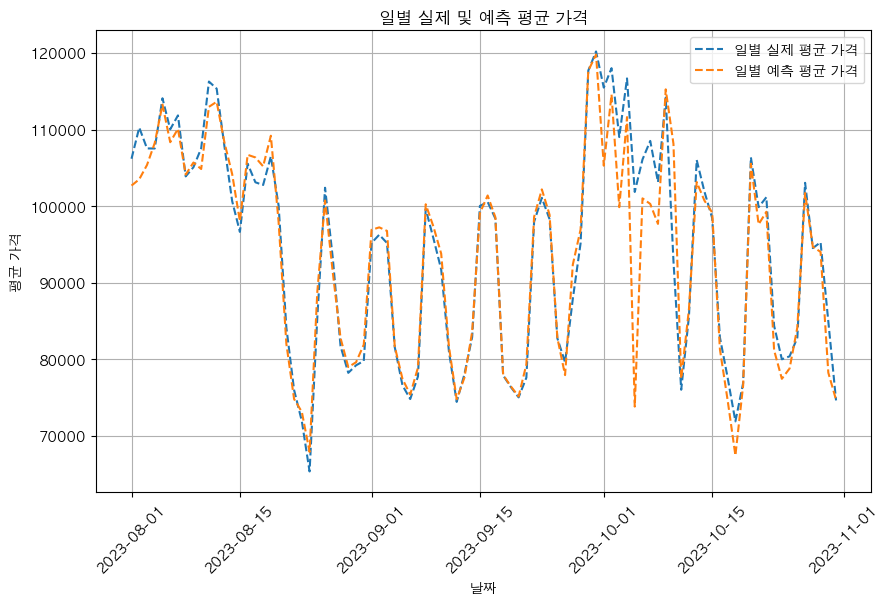

In [752]:
# 실제 가격과 날짜 컬럼만 추출
df_actual_prices = df_ml[['price', 'date']].copy()

# 날짜 컬럼을 datetime 형식으로 변환
df_actual_prices['date'] = pd.to_datetime(df_actual_prices['date'])

# 날짜별 실제 평균 가격 계산
daily_actual_avg_prices = df_actual_prices.groupby('date')['price'].mean().reset_index()

# 점선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(daily_actual_avg_prices['date'], daily_actual_avg_prices['price'], '--', label='일별 실제 평균 가격')

# 예측 가격과 날짜 컬럼만 추출
df_predicted_prices = df_ml[['Predicted_Price', 'date']].copy()

# 날짜 컬럼을 datetime 형식으로 변환
df_predicted_prices['date'] = pd.to_datetime(df_predicted_prices['date'])

# 날짜별 예측 평균 가격 계산
daily_predicted_avg_prices = df_predicted_prices.groupby('date')['Predicted_Price'].mean().reset_index()

# 예측 가격 그래프 그리기
plt.plot(daily_predicted_avg_prices['date'], daily_predicted_avg_prices['Predicted_Price'], '--', label='일별 예측 평균 가격')

plt.xlabel('날짜')
plt.ylabel('평균 가격')
plt.title('일별 실제 및 예측 평균 가격')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [753]:
# 조건 설정
condition = (df_ml['airline'] == 0)

# 조건을 만족하는 행들만 선택하여 'departure_time' 시리즈 생성
filtered_departure_time = df_ml[condition]['departure_time']

# 'departure_time' 시리즈에서 값들의 빈도수 계산
departure_time_counts = filtered_departure_time.value_counts()

# 빈도수가 가장 높은 값부터 정렬하여 출력
sorted_counts = departure_time_counts.sort_values(ascending=False)

# 결과 출력
print(sorted_counts)

departure_time
420     171
1100     61
1055     57
1140     51
1230     45
       ... 
460       1
495       1
365       1
1085      1
1065      1
Name: count, Length: 81, dtype: int64


In [754]:
import pandas as pd

# 2023년 8월 1일부터 2023년 10월 31일까지의 날짜 범위 생성
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-10-31')
date_range = pd.date_range(start_date, end_date)

# 새로운 row를 담을 리스트 생성
new_rows = []
for date in date_range:
    new_row = {
        'airline': '대한항공',
        'departure_time': 420,
        'arrival_time': 490,
        'departure_place': 'GMP',
        'arrival_place': 'CJU',
        'flight_time': 70,
        'seat': '일반석',
        'date': date
    }
    new_rows.append(new_row)

# 새로운 DataFrame 생성
new_df = pd.DataFrame(new_rows)

# 'day', 'holiday', 'peak_season' 컬럼 생성
new_df['day'] = [get_weekday(date) for date in new_df['date']]
new_df['holiday'] = [is_weekend_or_holiday(date.date(), holiday_list) for date in new_df['date']]
new_df['peak_season'] = [is_peak_season(date.date(), peak_seasons) for date in new_df['date']]

# 결과 확인
display(new_df)

,airline,departure_time,arrival_time,departure_place,arrival_place,flight_time,seat,date,day,holiday,peak_season
0,대한항공,420,490,GMP,CJU,70,일반석,2023-08-01,화요일,평일,성수기
1,대한항공,420,490,GMP,CJU,70,일반석,2023-08-02,수요일,평일,성수기
2,대한항공,420,490,GMP,CJU,70,일반석,2023-08-03,목요일,평일,성수기
3,대한항공,420,490,GMP,CJU,70,일반석,2023-08-04,금요일,평일,성수기
4,대한항공,420,490,GMP,CJU,70,일반석,2023-08-05,토요일,주말,성수기
...,...,...,...,...,...,...,...,...,...,...,...
87,대한항공,420,490,GMP,CJU,70,일반석,2023-10-27,금요일,평일,비수기
88,대한항공,420,490,GMP,CJU,70,일반석,2023-10-28,토요일,주말,비수기
89,대한항공,420,490,GMP,CJU,70,일반석,2023-10-29,일요일,주말,비수기
90,대한항공,420,490,GMP,CJU,70,일반석,2023-10-30,월요일,평일,비수기


In [755]:
# 새로운 데이터프레임에 라벨 인코딩을 적용할 컬럼들 선택
columns_to_encode_new = ["airline", "seat", "day", "holiday", "departure_place", "arrival_place", "peak_season"]

# 기존 LabelEncoder 객체들을 활용하여 라벨 인코딩 적용
for column in columns_to_encode_new:
    label_encoder = label_encoders[column]  # 현재 컬럼에 대한 LabelEncoder 객체 가져오기
    new_df[column] = label_encoder.transform(new_df[column])

# 이제 새로운 new_df 데이터프레임을 이용해 예측을 진행할 수 있습니다
# X_new에는 학습할 때 사용한 feature 컬럼들이 포함되어야 합니다
X_new = new_df.drop(['date', 'arrival_time'], axis=1)
y_new_pred_xgb = xgb_model.predict(X_new)

# 예측 결과를 new_df 데이터프레임에 추가합니다
new_df['Predicted_Price'] = y_new_pred_xgb

# 예측된 가격을 담고 있는 new_df 데이터프레임을 출력합니다
print(new_df[['Predicted_Price']])

    Predicted_Price
0        127,423.80
1        130,048.25
2        130,936.21
3        130,124.02
4        131,259.42
..              ...
87       107,287.57
88       128,148.07
89       109,571.41
90        97,750.72
91        98,748.26

[92 rows x 1 columns]


In [756]:
display(new_df)

,airline,departure_time,arrival_time,departure_place,arrival_place,flight_time,seat,date,day,holiday,peak_season,Predicted_Price
0,0,420,490,2,1,70,1,2023-08-01,6,2,1,"127,423.80"
1,0,420,490,2,1,70,1,2023-08-02,2,2,1,"130,048.25"
2,0,420,490,2,1,70,1,2023-08-03,1,2,1,"130,936.21"
3,0,420,490,2,1,70,1,2023-08-04,0,2,1,"130,124.02"
4,0,420,490,2,1,70,1,2023-08-05,5,1,1,"131,259.42"
...,...,...,...,...,...,...,...,...,...,...,...,...
87,0,420,490,2,1,70,1,2023-10-27,0,2,0,"107,287.57"
88,0,420,490,2,1,70,1,2023-10-28,5,1,0,"128,148.07"
89,0,420,490,2,1,70,1,2023-10-29,4,1,0,"109,571.41"
90,0,420,490,2,1,70,1,2023-10-30,3,2,0,"97,750.72"


In [757]:
import pandas as pd

# 조건 설정
condition = (
    (df_ml['airline'] == 0) &
    (df_ml['departure_time'] == 420) &
    (df_ml['departure_place'] == 2) &
    (df_ml['arrival_place'] == 1) &
    (df_ml['seat'] == 1)
)

# 조건을 만족하는 데이터프레임 생성
filtered_df = df_ml[condition]

# 결과 출력
display(filtered_df)

,airline,date,departure_time,arrival_time,departure_place,arrival_place,flight_time,seat,price,day,holiday,year,month,days,peak_season,month_day,Predicted_Price
110,0,2023-08-01,420,490,2,1,70,1,129700,6,2,2023,8,1,1,08-01,"127,423.80"
527,0,2023-08-02,420,490,2,1,70,1,129700,2,2,2023,8,2,1,08-02,"130,048.25"
5406,0,2023-08-10,420,490,2,1,70,1,175900,1,2,2023,8,10,1,08-10,"130,936.21"
7083,0,2023-08-13,420,490,2,1,70,1,129700,4,1,2023,8,13,1,08-13,"131,748.42"
7710,0,2023-08-14,420,490,2,1,70,1,129700,3,2,2023,8,14,1,08-14,"129,363.42"
13845,0,2023-08-26,420,490,2,1,70,1,129700,5,1,2023,8,26,0,08-26,"128,148.07"
16236,0,2023-08-29,420,490,2,1,70,1,98700,6,2,2023,8,29,0,08-29,"98,748.26"
19684,0,2023-09-02,420,490,2,1,70,1,129700,5,1,2023,9,2,0,09-02,"128,148.07"
22065,0,2023-09-05,420,490,2,1,70,1,98700,6,2,2023,9,5,0,09-05,"98,748.26"
31618,0,2023-09-17,420,490,2,1,70,1,112700,4,1,2023,9,17,0,09-17,"109,571.41"


/var/folders/5x/8_5m_9v57bz_btfk508ff3hc0000gn/T/ipykernel_27959/2496521770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')


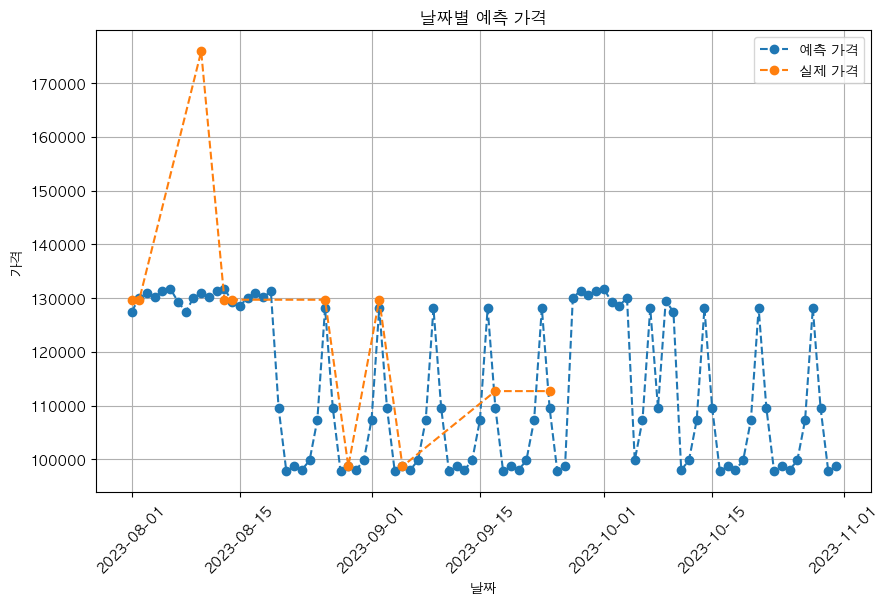

In [758]:
# 'date' 컬럼의 데이터를 날짜 형식으로 변환하고 데이터프레임의 인덱스로 설정
new_df['date'] = pd.to_datetime(new_df['date'], format='%Y-%m-%d')
new_df.set_index('date', inplace=True)
filtered_df['date'] = pd.to_datetime(filtered_df['date'], format='%Y-%m-%d')
filtered_df.set_index('date', inplace=True)
# 날짜별 예측 가격 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(new_df.index, new_df['Predicted_Price'], marker='o', linestyle='--', label='예측 가격')
plt.plot(filtered_df.index, filtered_df['price'], marker='o', linestyle='--', label='실제 가격')
plt.xlabel('날짜')
plt.ylabel('가격')
plt.title('날짜별 예측 가격')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()